# Лабораторная работа №1 

## Методы нулевого и первого порядка 
***

Команда **"Зелёные шапки"** в составе: Заречнев Алексей, Петрасюк Алексей, Халили Алина, Галимова Ярослава (счастливые обитатели группы M3236)  
Ссылка на репозиторий: 
***

Метод градиентного спуска — численный метод нахождения локального минимума или максимума функции с помощью движения вдоль градиента с различными стратегиями выбора шага. В ходе этой лабораторной работы были написаны несколько классов, реализующих удобный интерфейс для анализа функций методами градиентного спуска и одномерного поиска.

Метод градиентного спуска реализован в классе ```gradient_decent.py``` с помощью метода ```find_min``` :

In [ ]:
def find_min(self, start: List[float], max_iterations: int) -> float:
    self.__init(start)
        for i in range(max_iterations):
            h = self.learning_rate_scheduling(self.x, i, self.f)
            self.path.append(self.x)
            grad = gradient(self.f, self.x, self.eps)
            xx = []
            for j in range(len(self.x)):
                coord = self.x[j] - h * grad[j]
                coord = max(coord, self.bounds[j][0])
                coord = min(coord, self.bounds[j][1])
                xx.append(coord)
            if self.x == xx:
                break
            self.x = xx
        return self.f(self.x)

```start: List[float]``` - стартовая точка, в которой начнём поиск  
```max_iterations: int``` - максимальное количество итераций спуска (выполняет свойство предохранителя и запрещает нашему коду выполняться бесконечно долго)  
Возвращаемое значение - минимум полученный в ходе спуска  
Количество итераций определеяется максимальным количеством итераций и погрешностью. Если шаг слишком мал и градиент практически не меняется, то есть мы "топчемся" на месте, работа функции завершается

Аналогичным образом определена функция ```find_max```

Для того, чтобы наглядно промедонстрировать работоспособность кода, также была создана вспомогательная программа ```graphics_plotter.py```, которая помогает нам рисовать красивые 2d и 3d графики. Различные дополнительные функции, в том числе стратегии выбора шага, реализованы в ```lrs.py```

Давайте проанализируем работу этого метода на конкретных примерах:
+ $x^2+3y^2+xy-1$
+ $6x^4-17x^3+8x^2+5x-2$

In [41]:
from graphics_plotter import GraphicsPlotter
from gradient_decent import GradientDecent
from lrs import constant, exponential_decay, polynomial_decay, armiho, wolfe

def pretty_print(descent: GradientDecent, name: str, find_result: float):
    print(name, ": find min value: ", find_result)
    print(name, ": find min value in: ", descent.get_path()[-1])
    print(name, ": steps count: ", len(descent.get_path()))

### $x^2+3y^2+xy-1$

+ Первой функцией возьмём обычный многочлен от двух переменных $x^2 + 3y^2 + xy - 1$ и сделаем градиентный спуск с постоянным методом планирования шага  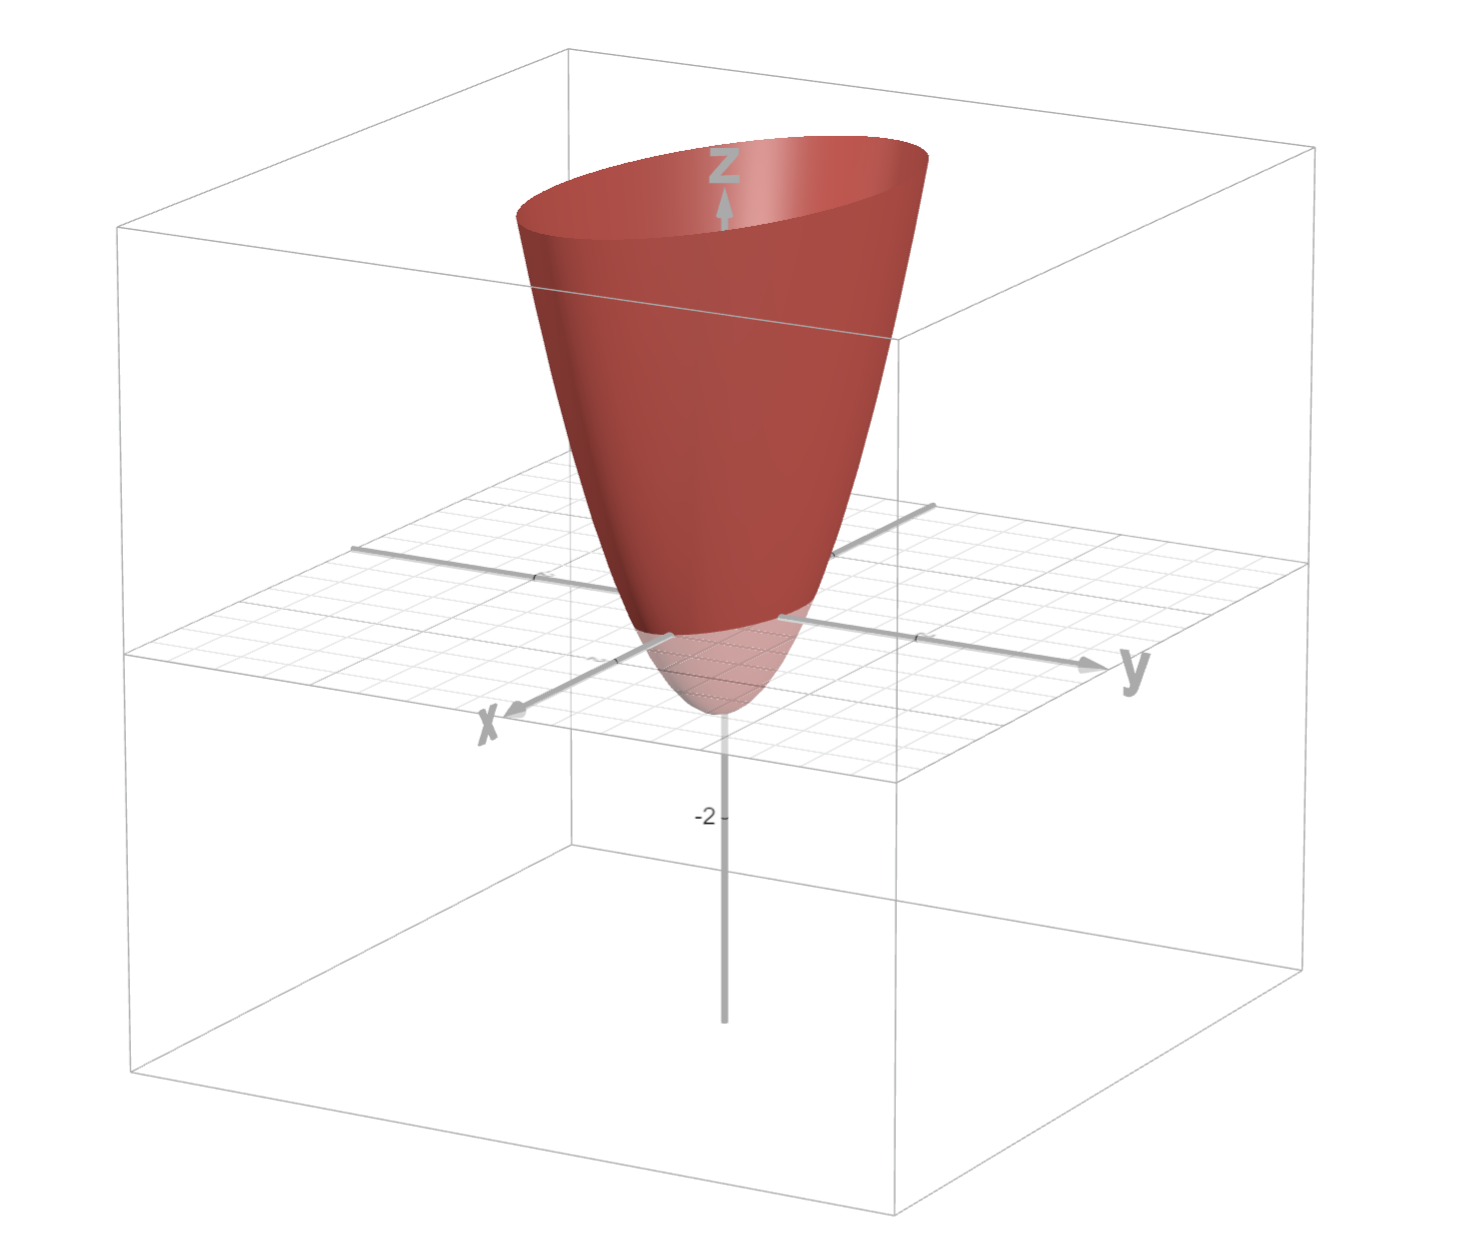

CONST_1 : find min value:  -0.9999988863932646
CONST_1 : find min value in:  [0.0010924143400954378, -0.00026307331402453116]
CONST_1 : steps count:  858


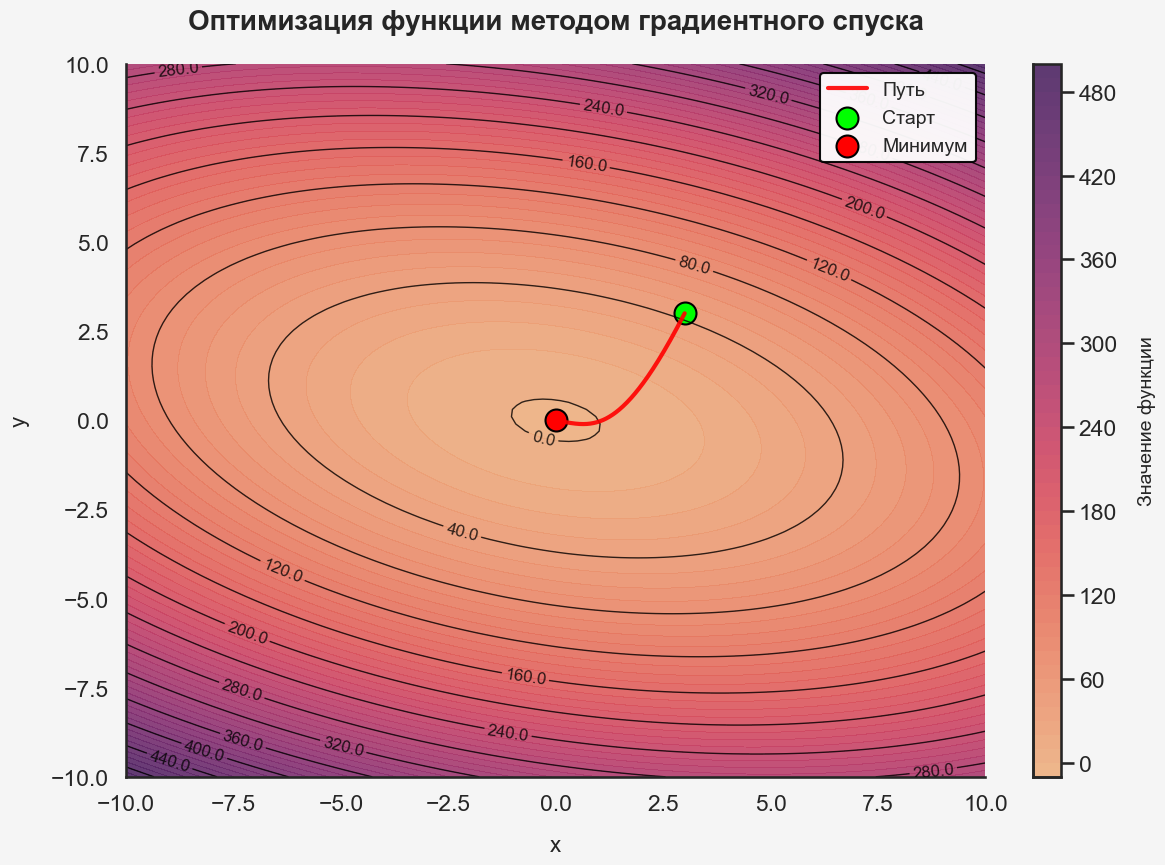

CONST_2 : find min value:  373.99989992828534
CONST_2 : find min value in:  [-5.00000500107678, -10.0]
CONST_2 : steps count:  1000


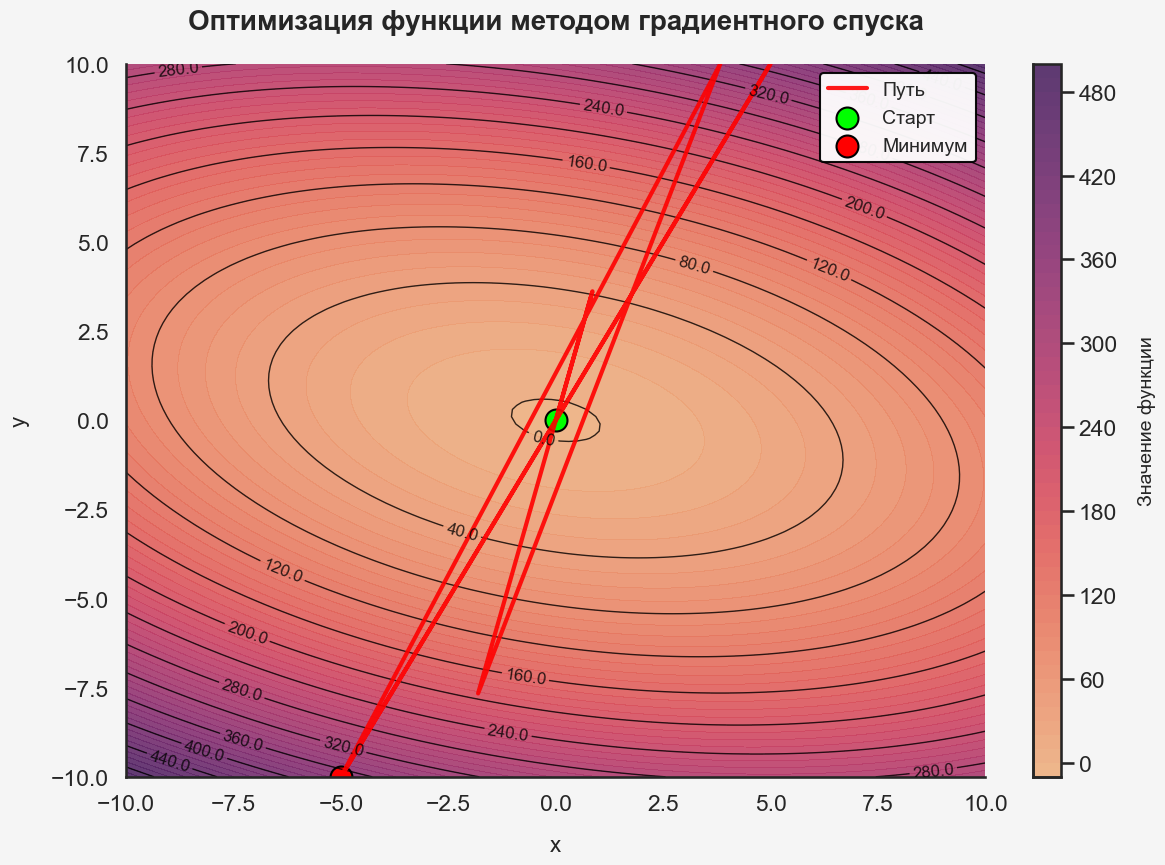

In [12]:
func = lambda x: x[0] ** 2 + 3 * x[1] ** 2 + x[1] * x[0] - 1
test_descent_1 = GradientDecent(constant(0.005), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)

pretty_print(test_descent_1, "CONST_1", test_descent_1.find_min([3, 3], 1000))
test_plotter_1 = GraphicsPlotter(test_descent_1)
test_plotter_1.plot()

test_descent_2 = GradientDecent(constant(0.5), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)

pretty_print(test_descent_2, "CONST_2", test_descent_2.find_min([0, 0], 1000))
test_plotter_2 = GraphicsPlotter(test_descent_2)
test_plotter_2.plot()

Что произошло? Если выставить большую константу (например, мы рассматривали случай с ```constant(0.5)```), высок риск "гулять" по области значения в произвольных направлениях. Например, даже если встать изначально в точку, достаточно близкую к минимуму, то уже спустя ~15 шагов визуально на графике будет видно, как мы сдвинулись на небольшой вектор. Это происходит из-за того, что градиент считается с погрешностью, и даже небольшая погрешность, умножаясь на большую константу, отдаляет нас от искомой точки. Если сделать ~50 шагов, то "прогулка" по нашей области станет совсем далека от истины. В этом случае метод работает некорректно. Следовательно, константу нужно подбирать меньше. Нас удовлетворил показатель ```constant(0.005)```. Но и здесь есть нюансы, из-за небольшой константы наши шаги тоже становятся маленькими, поэтому даже 100 итераций не хватает, чтобы дойти до точки минимума. Но, подняв количество допустимых шагов до 1000, мы получаем ответ -0.9999999121823524, который очень близок к правильному (-1).

+ Мы поняли, что метод градиентного спуска с помощью постоянного планирования шага не является оптимальным: при большой константе он выдаёт абсолютно неверную траекторию и неправильный ответ, а в случае с маленькой константой ему требуется много итераций. Давайте рассмотрим ещё один простой метод на примере той же функции. Этот метод относится к функциональным методам планирования шага и называется экспоненциальным затуханием. Он не сильно отличается от предыдущего метода, поскольку тоже заключается в домножении градиента на некоторую константу, которая не зависит от поведения рассматриваемой функции. Но в отличие от постоянного метода планирования шага, здесь шаг зависит ещё и от номера итерации. Наша реализация этого метода выглядит следующим образом:

In [ ]:
def exponential_decay(h0: float, l: float) -> LRS:
    return lambda x, k, f: h0 * math.e**(-l*k)

В теории можно выделить сразу несколько плюсов этого метода: 
1. В начале пути шаг большой, мы двигаемся быстро и так же быстро сужаем область поиска
2. В конце пути шаг маленький, поэтому чем мы ближе к результату, тем точнее мы приближаемся к искомой точке.
   
Но так ли это хорошо на практике? 

EXP : find min value:  -0.9999999997952587
EXP : find min value in:  [-3.3867110598921634e-06, -7.481816301156007e-06]
EXP : steps count:  30


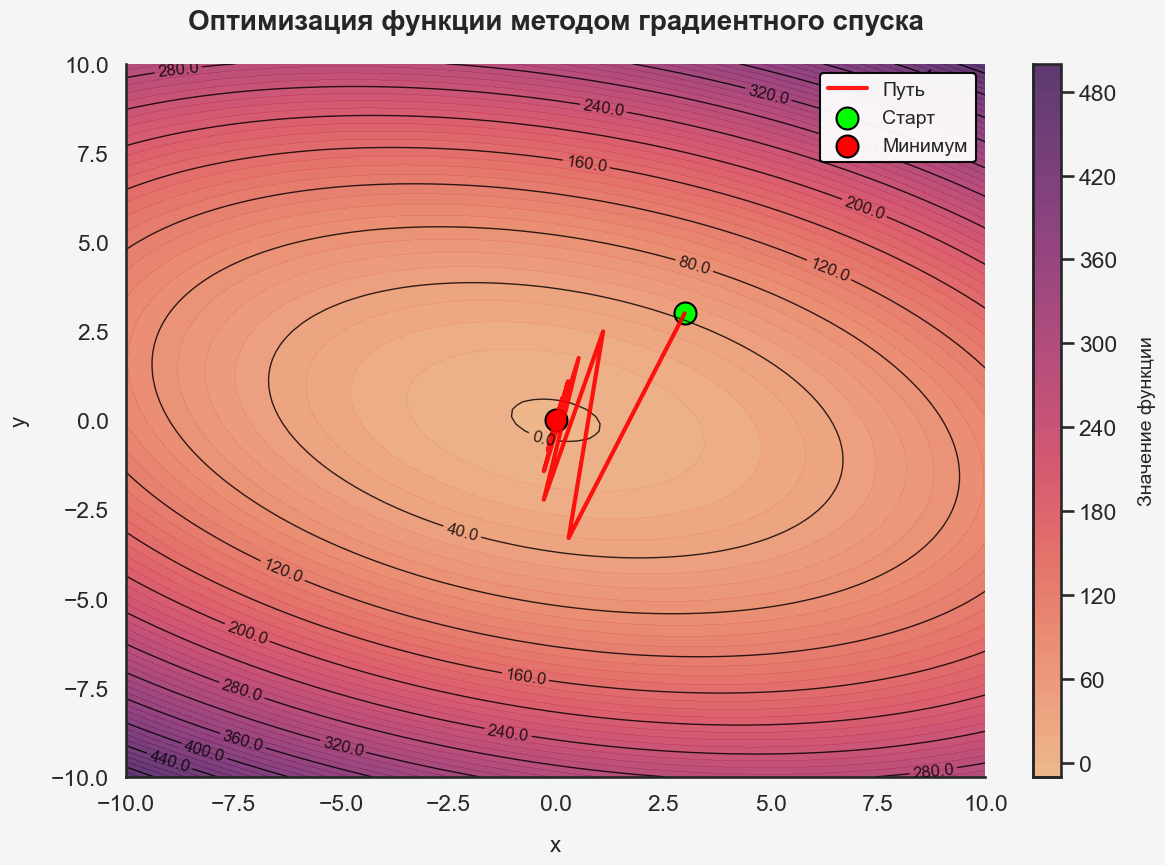

In [34]:
func = lambda x: x[0] ** 2 + 3 * x[1] ** 2 + x[1] * x[0] - 1
test_descent = GradientDecent(exponential_decay(0.3, 0.01), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)

result = test_descent.find_min([3, 3], 12000)
test_plotter = GraphicsPlotter(test_descent)

pretty_print(test_descent, "EXP", result)

test_plotter.plot()

Мы чётко видим, что на данном примере алгоритму потребовалось в 28 раз меньше шагов относительно предыдущего. Более того, важно заметить, что если мы запускаем алгоритм из точки, близкой к экстремуму, мы уже не получаем произвольных "блужданий", как это было в предыдущем случае. Из всего этого можно сделать вывод, что данный метод работает эффективнее предыдущего. Но важно понимать, что в отличие от метода постоянного шага здесь очень важно корректно подобрать параметры ```exponential_decay```, поскольку отличие параметров даже в два раза может повлечь за собой большие изменения в скорости работы алгоритма. Это естественно для любых алгоритмов поиска шага, которые не зависят от функции, по которой "гуляют", но именно в данном случае это становится заметнее всего.

+ Разобравшись с экспоненциальным затуханием, можно также рассмотреть полиномиальное затухание. Это ещё один функциональный метод планирования шага. В нашем случае он реализован следующим образом:

In [ ]:
def polynomial_decay(a: float, b: float) -> LRS:
    return lambda x, k, f: (1.0 / math.sqrt(k + 1)) * (b * k + 1)**(-a)

При правильном подборе подставляемых в функцию значений, полиномиальное затухание обещаем нам предъявлять более плавные шаги, нежели в предыдущих двух методах. Давайте тоже рассмотрим на примере.

POLY : find min value:  -0.9990212931510032
POLY : find min value in:  [0.0324205661780559, -0.007654711056263026]
POLY : steps count:  517


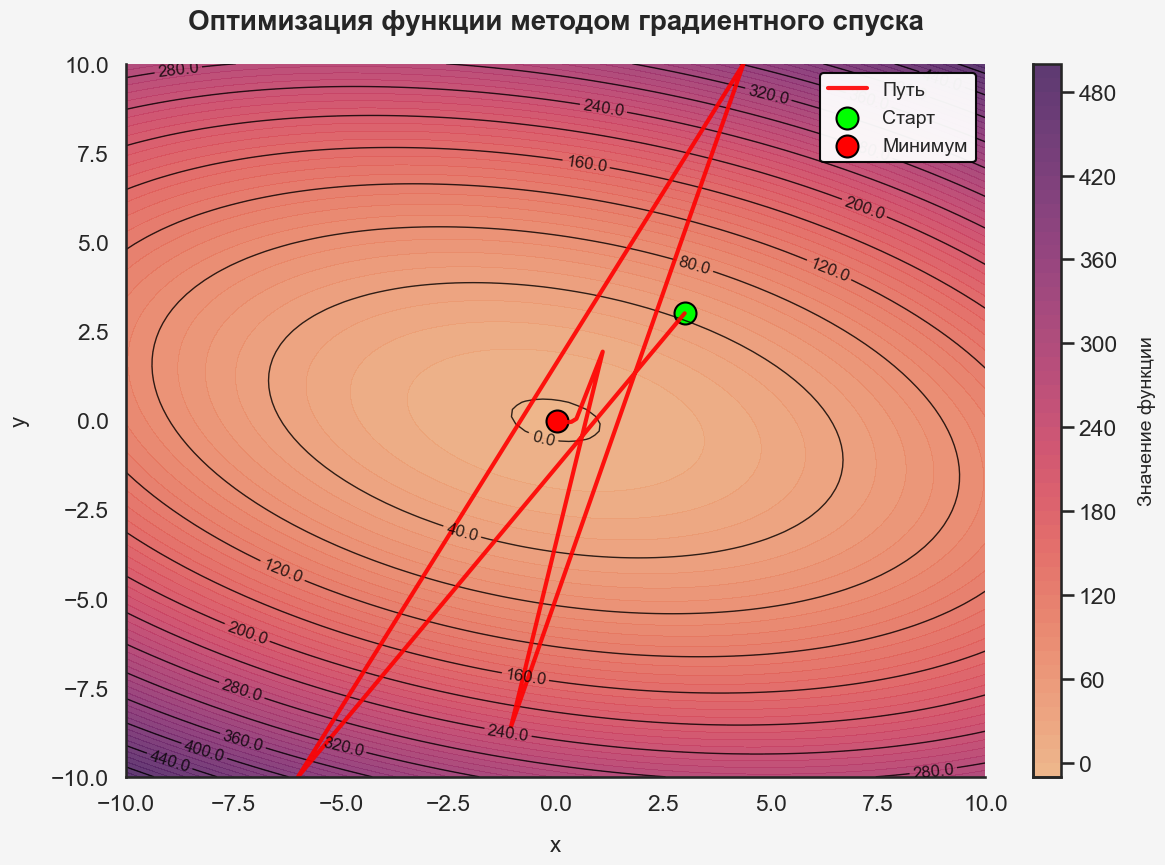

In [60]:
func = lambda x: x[0] ** 2 + 3 * x[1] ** 2 + x[1] * x[0] - 1
test_descent = GradientDecent(polynomial_decay(1, 0.5), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)

result = test_descent.find_min([3, 3], 1000)
test_plotter = GraphicsPlotter(test_descent)

pretty_print(test_descent, "POLY", result)

test_plotter.plot()

Самым универсальным способом запуска данного метода является запуск с такими параметрами:  ```polynomial_decay(1, 0.5)```  
Конкретно в нашем случае нам удавалось добиться высокой точности поиска максимума с немного изменёнными параметрами (```polynomial_decay(0.5, 0.05)```) всего лишь за 28 шагов. Но в общем случае подбор параметров является вычислительно сложной задачей, так что пока будем просто анализировать на конкретных примерах, тем более "классические" параметры возвращают нам очень точный результат за небольшое число итераций. В отличие от экспоненциального затухания, на поздних этапах величина шага меняется более плавно, что делает этот метод более универсальным, пусть иногда и более затратным по времени.

##### Промежуточный вывод  
Мы рассмотрели 3 простейших метода планирования шага. Все они хороши тем, что за практически константное время (можно даже сказать, что за O(1)) выдают нам то, насколько далеко мы хотим сделать наш шаг по направлению градиента. Чем они плохи? Во-первых, они никак не зависят от анализируемой функции. А значит, то, что будет хорошо работать на одних функциях, может работать плохо или даже не работать на других. Где-то потребуется изменить параметры запуска, а где-то даже играет роль стартовая точка, как, например, в случае с константным методом. Во-вторых, все они требуют доработки в виде добавления импульса к каждому из алгоритмов, поскольку все они могут "застревать" в локальных минимумах. Впрочем, к этому вопросу мы ещё вернёмся.

+ Давайте теперь рассмотрим методы, которые принимают во внимание поведение функции и проверяют некоторое условие. Перед вами правило Армихо. Кратко его можно характеризовать словами "правило достаточного убывания". В ходе проверки на условие "достаточного убывания" мы должны построить линейную функцию из нашего месторасположения и подобрать шаг, итеративно умножая его на параметризированную константу, пока точка не будет лежать ниже прямой, заданной ранее. Здесь сразу понятно, что время исследования функции на каждом шаге будет зависеть и от параметров, и от самой функции, поэтому однозначного ответа в общем случае дать невозможно: мы один раз считаем градиент, а затем проверяем условие, пока оно не начнёт выполняться.

Условие Армихо: $f(x + alpha * d) <= f(x) + c * alpha * grad(f(x))^T * d$  
d - направление поиска (в нашем случае $\pm grad(f(x))$)  
c - параметр (0 < c < 1), определяющий степень требуемого уменьшения (обычно выбирается небольшое значение, например, 0.01)
alfa - искомая длина шага

ARM_1 : find min value:  -0.9999999991155639
ARM_1 : find min value in:  [3.0292916317600587e-05, -1.2520213297703788e-06]
ARM_1 : steps count:  19


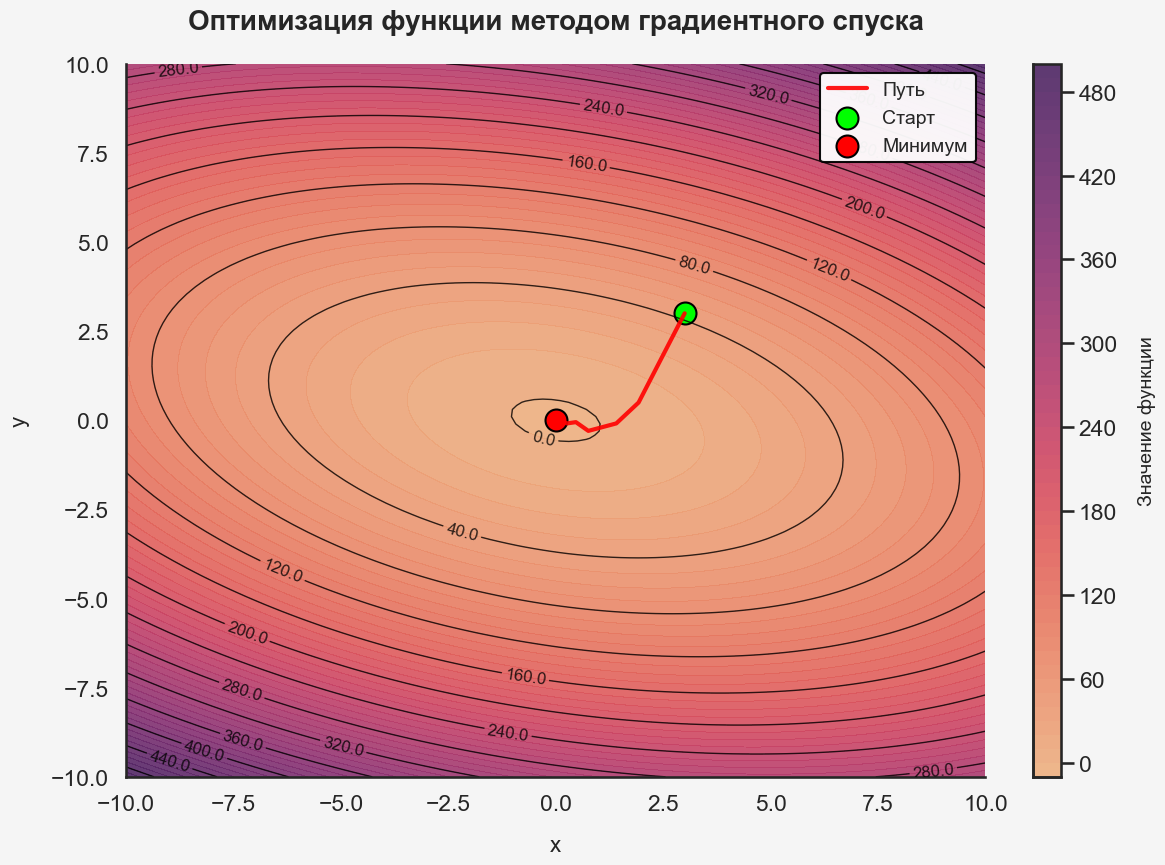

ARM_2 : find min value:  -0.9999999991155639
ARM_2 : find min value in:  [9.988269992820327e-06, 8.471804234063216e-07]
ARM_2 : steps count:  21


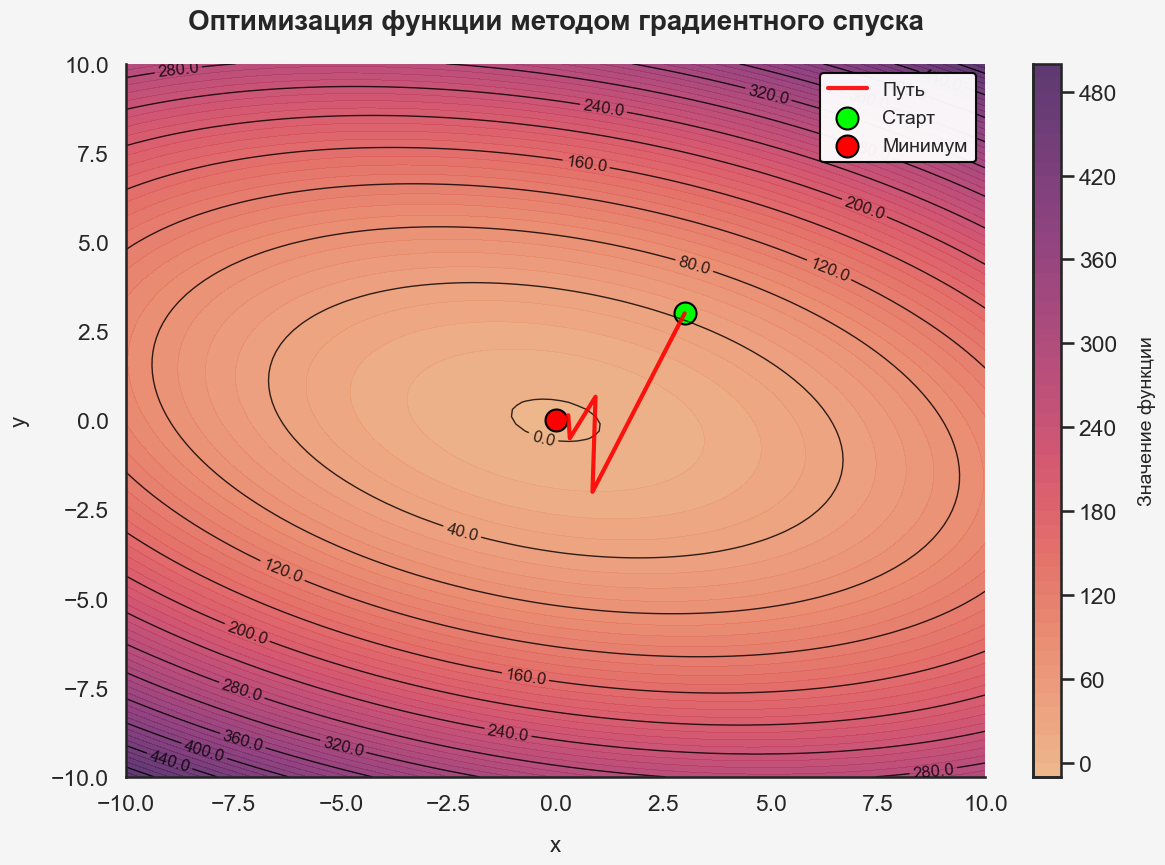

In [59]:
func = lambda x: x[0] ** 2 + 3 * x[1] ** 2 + x[1] * x[0] - 1
test_descent = GradientDecent(armiho(0.5, 0.5), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)
result = test_descent.find_min([3, 3], 1000)
test_plotter = GraphicsPlotter(test_descent)

test_descent_2 = GradientDecent(armiho(0.1, 0.5), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)
result_2 = test_descent_2.find_min([3, 3], 1000)
test_plotter_2 = GraphicsPlotter(test_descent_2)

pretty_print(test_descent, "ARM_1", result)
test_plotter.plot()

pretty_print(test_descent_2, "ARM_2", result)
test_plotter_2.plot()

Интересно будет рассмотреть этот метод и на других функциях, чтобы хорошо пронаблюдать то, что этот метод опирается на поведение самой функции. Здесь мы видим, что за всего 19 шагов достигнут минимум с очень высокой точностью. Сама траектория напоминает траекторию постоянного метода планирования шага или экспоненциального затухания с маленьким первым коэффициентом. На просторах интернета самыми универсальными параметрами считаются ```armiho(0.1, 0.5)```, с такими параметрами результат достигается тоже быстро, траектория похожа на экспоненциальное затухание, но количество итерация в 1.5 раза меньше.

+ Рассмотрим ещё один похожий метод. Это правило Вольфе. Условия Вольфе — это набор из двух неравенств: правило Армихо и условие кривизны:  
      $f(x + a * p) <= f(x) + c1 * a * graf(f)^T * p$  
      $grad(f(x + ap))^T * p >= c2 * grad(f(x))^T * p$
Это комментарии из нашего кода, помогающие нам писать сам метод, а читающему - разобраться с тем, что происходит. С правилом Армихо мы уже познакомились, а условие кривизны требует, чтобы наклон функции в направлении поиска уменьшился "достаточно сильно" и предотвращает "застревание" алгоритма, чего так не хватало в предыдущих методах, где шаги могли становиться слишком маленькими и так и не достигать искомой точки. Из всего этого хочется сразу сделать теоретический вывод, что метод Вольфе работает точнее условия Армихо, и мы можем считать его более надёждым, однако от требует вычисления градиента на каждом шаге, что делает его более "дорогим". Давайте поймём, так ли это на самом деле?

WOLFE : find min value:  -0.9999999999045809
WOLFE : find min value in:  [5.599406824573417e-06, 3.7812306589062003e-06]
WOLFE : steps count:  23


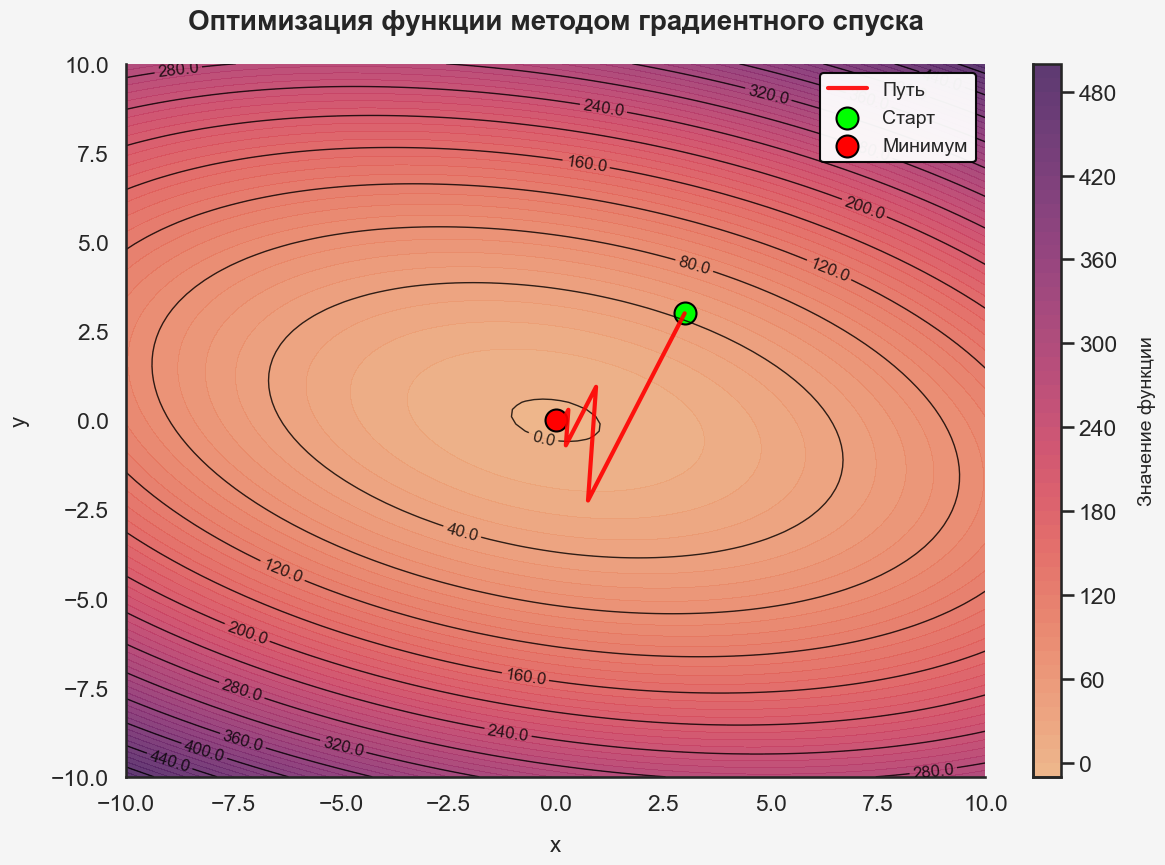

In [53]:
func = lambda x: x[0] ** 2 + 3 * x[1] ** 2 + x[1] * x[0] - 1
test_descent = GradientDecent(wolfe(0.0001, 0.9), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)

result = test_descent.find_min([3, 3], 1200)
test_plotter = GraphicsPlotter(test_descent)

pretty_print(test_descent, "WOLFE", result)

test_plotter.plot()

По умолчанию хорошим набором параметров считаются параметры ```wolfe(0.0001, 0.9)```. Мы поэкспериментировали и с другими параметрами, но значительно уменьшить число шагов нам не удалось. Метод действительно очень быстро и с высокой точностью возвращает ответ.

+ И последней реализованной нами стратегией выбора шага является метод Гольдштейна. Стратегия также состоит из проверки двух условий: условия Армихо и условия Гольдштейна. Второе условие гарантирует, что функция не уменьшается слишком сильно, предотвращает выбор слишком маленьких шагов, которые могут замедлить сходимость.  Оно как бы "подпирает" функцию снизу:  
  $f(x + a * p) <= f(x) + c1 * a * grad(f)^T * p$  
  $f(x + a * p) >= f(x) + (1 - c1) * a * grad(f)^T * p$  


GOLD : find min value:  -0.9999999998823327
GOLD : find min value in:  [-1.6929956065777054e-07, 6.2902984740282815e-06]
GOLD : steps count:  77


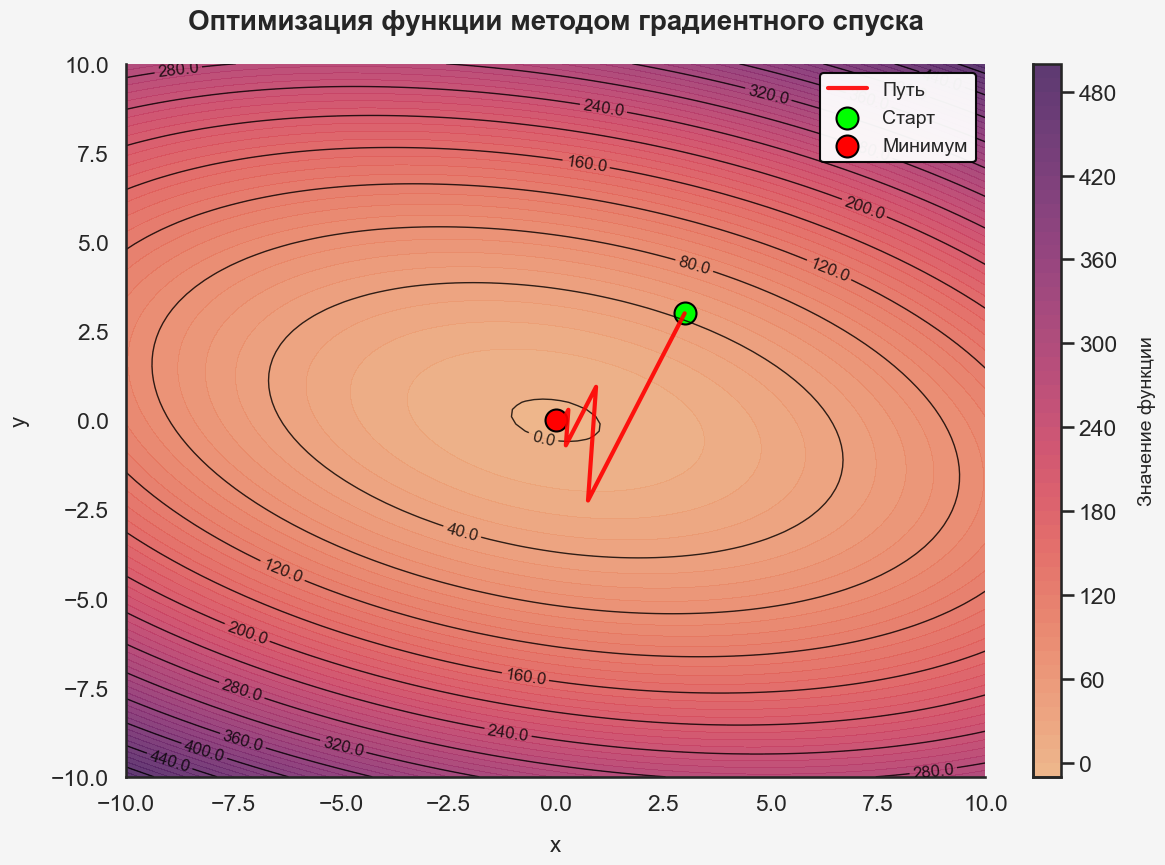

In [58]:
func = lambda x: x[0] ** 2 + 3 * x[1] ** 2 + x[1] * x[0] - 1
test_descent = GradientDecent(goldstein(0.0001, 0.9), func, [[-10.0, 10.0], [-10.0, 10.0]], 0.00001)

result = test_descent.find_min([3, 3], 1200)
test_plotter = GraphicsPlotter(test_descent)

pretty_print(test_descent, "GOLD", result)

test_plotter.plot()

Как результат - мы получаем чуть более долгий алгоритм. На просторах интернета также многие считают, что метод Вольфе не уступает методу Гольдштейна в точности результатов, но при этом работает быстрее. Ровно это мы и наблюдаем.

#### Общие выводы
Мы проанализировали 6 стратегий выбора шага на простом примере. Все они выдали правильный результат при определённых параметрах запуска. Скорость их работы и количество шагов тоже во многом зависят от этих параметров. Но в отличие от первых трёх методов, стратегии Армихо, Гольдштейна и Вольфе не так сильно меняют траекторию поиска или количество исполь параметров. Их поведение характеризуется ещё и функцией, на которй происходит поиск. Поэтому можно сделать промежуточный вывод - последние три стратегии более универсальны. Но так ли это на более сложных и замысловатых функциях? Давайте рассмотрим далее.